<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_generators_and_1_Classifier_ver5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files


In [140]:
!wget "https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5"

--2018-12-04 18:14:10--  https://github.com/rajagopalmotivate/DeepLearnIITMA1/blob/master/model2001s%20(1).h5
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘model2001s (1).h5.8’

model2001s (1).h5.8     [  <=>               ]  52.65K   144KB/s    in 0.4s    

2018-12-04 18:14:12 (144 KB/s) - ‘model2001s (1).h5.8’ saved [53917]



In [0]:
def load_dataold():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
    plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

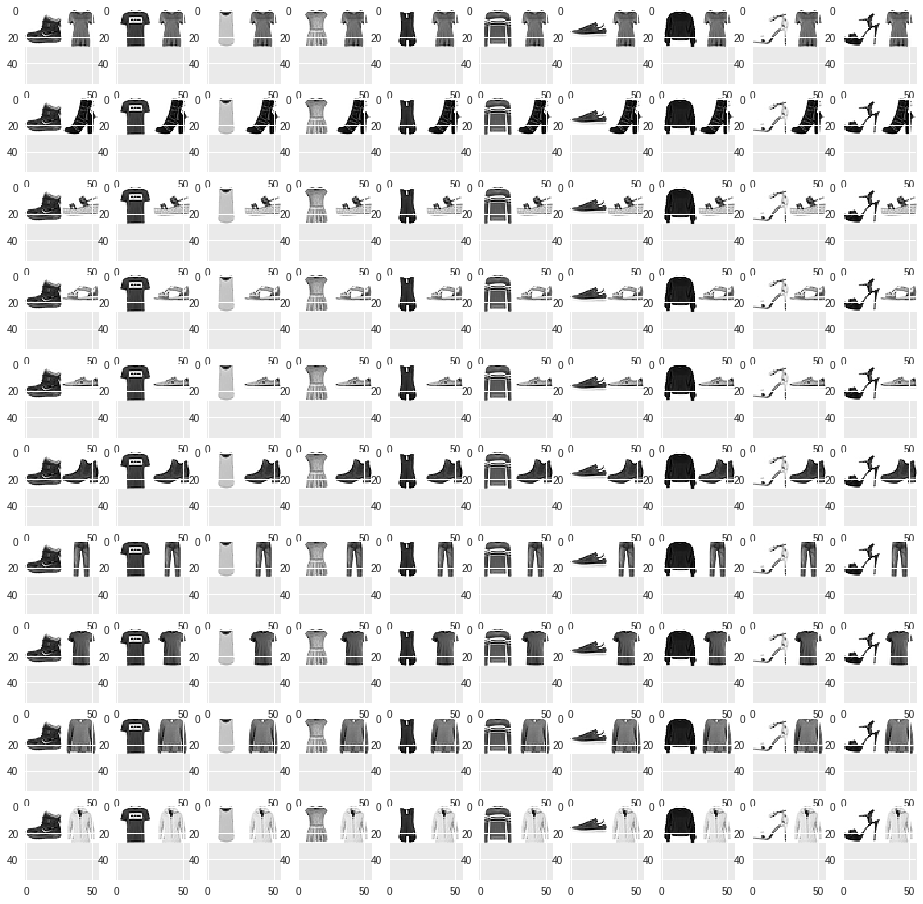

(60000, 28, 28)
(10000, 56, 56)


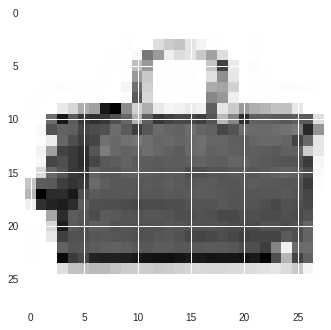

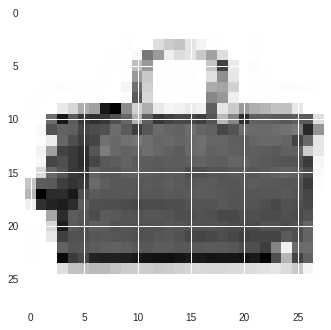

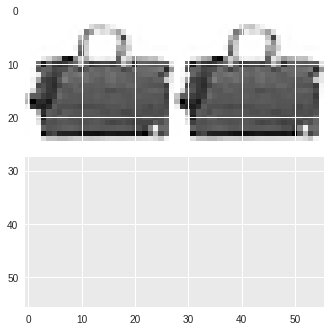

In [143]:
X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_databydatasetname(2)

    num_examples = X_train.shape[0]/10
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def build_modelsNEW():
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    models = [generator1, generator2]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        
    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    
    return generator1, discriminator, combined  

In [0]:
def main():
    generator, discriminator, combined = build_modelsNEW()

    train(generator, discriminator, combined,
          epochs=1, batch_size=32, save_interval=1)
    
    
    generator.save('generator1.h5')
    discriminator.save('discriminator1.h5')
    combined.save('combined1.h5')
    


-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/187 [D loss: 0.830945, acc.: 46.88%] [G loss: 0.700361]


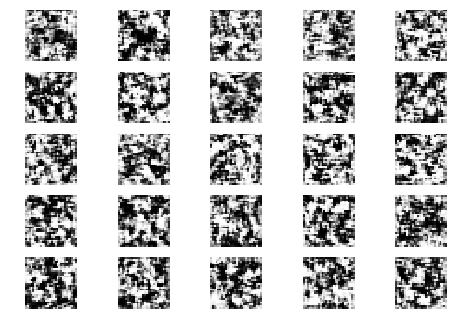

Epoch 0 Batch 1/187 [D loss: 0.665932, acc.: 53.12%] [G loss: 0.777772]
Epoch 0 Batch 2/187 [D loss: 0.684039, acc.: 53.12%] [G loss: 1.037761]
Epoch 0 Batch 3/187 [D loss: 0.421367, acc.: 81.25%] [G loss: 1.054126]
Epoch 0 Batch 4/187 [D loss: 0.440524, acc.: 84.38%] [G loss: 1.110339]
Epoch 0 Batch 5/187 [D loss: 0.398508, acc.: 84.38%] [G loss: 1.334018]
Epoch 0 Batch 6/187 [D loss: 0.456997, acc.: 75.00%] [G loss: 1.282098]
Epoch 0 Batch 7/187 [D loss: 0.503429, acc.: 78.12%] [G loss: 1.152143]
Epoch 0 Batch 8/187 [D loss: 0.338873, acc.: 84.38%] [G loss: 1.050969]
Epoch 0 Batch 9/187 [D loss: 0.413676, acc.: 81.25%] [G loss: 1.163047]
Epoch 0 Batch 10/187 [D loss: 0.417357, acc.: 84.38%] [G loss: 1.277627]
Epoch 0 Batch 11/187 [D loss: 0.259734, acc.: 96.88%] [G loss: 1.276383]
Epoch 0 Batch 12/187 [D loss: 0.351872, acc.: 84.38%] [G loss: 1.247363]
Epoch 0 Batch 13/187 [D loss: 0.523237, acc.: 75.00%] [G loss: 1.237282]
Epoch 0 Batch 14/187 [D loss: 0.338609, acc.: 87.50%] [G los

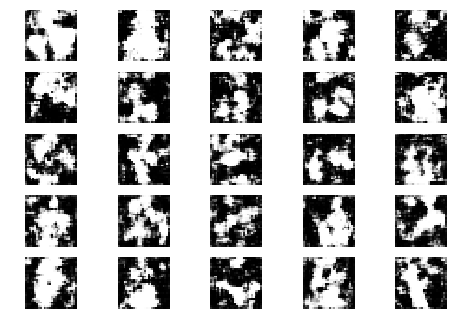

Epoch 0 Batch 51/187 [D loss: 0.426520, acc.: 84.38%] [G loss: 0.373114]
Epoch 0 Batch 52/187 [D loss: 0.169728, acc.: 96.88%] [G loss: 0.558227]
Epoch 0 Batch 53/187 [D loss: 0.155327, acc.: 93.75%] [G loss: 0.648562]
Epoch 0 Batch 54/187 [D loss: 0.229103, acc.: 93.75%] [G loss: 0.268574]
Epoch 0 Batch 55/187 [D loss: 0.077241, acc.: 100.00%] [G loss: 0.284162]
Epoch 0 Batch 56/187 [D loss: 0.246088, acc.: 87.50%] [G loss: 0.363299]
Epoch 0 Batch 57/187 [D loss: 0.289107, acc.: 90.62%] [G loss: 0.369280]
Epoch 0 Batch 58/187 [D loss: 0.346171, acc.: 87.50%] [G loss: 0.241100]
Epoch 0 Batch 59/187 [D loss: 0.119813, acc.: 100.00%] [G loss: 0.296920]
Epoch 0 Batch 60/187 [D loss: 0.245513, acc.: 90.62%] [G loss: 0.191283]
Epoch 0 Batch 61/187 [D loss: 0.140413, acc.: 96.88%] [G loss: 0.188617]
Epoch 0 Batch 62/187 [D loss: 0.293930, acc.: 90.62%] [G loss: 0.181170]
Epoch 0 Batch 63/187 [D loss: 0.206445, acc.: 96.88%] [G loss: 0.294189]
Epoch 0 Batch 64/187 [D loss: 0.213678, acc.: 93.

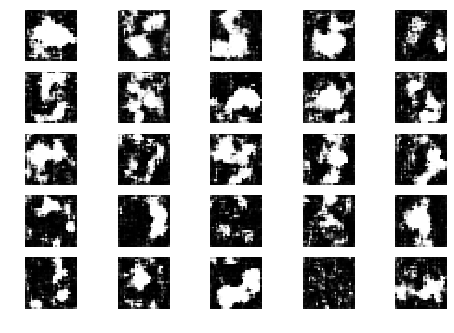

Epoch 0 Batch 101/187 [D loss: 0.152690, acc.: 96.88%] [G loss: 0.040076]
Epoch 0 Batch 102/187 [D loss: 0.119873, acc.: 96.88%] [G loss: 0.105653]
Epoch 0 Batch 103/187 [D loss: 0.057346, acc.: 100.00%] [G loss: 0.038982]
Epoch 0 Batch 104/187 [D loss: 0.314947, acc.: 87.50%] [G loss: 0.015822]
Epoch 0 Batch 105/187 [D loss: 0.202923, acc.: 90.62%] [G loss: 0.011789]
Epoch 0 Batch 106/187 [D loss: 0.019968, acc.: 100.00%] [G loss: 0.061493]
Epoch 0 Batch 107/187 [D loss: 0.284392, acc.: 90.62%] [G loss: 0.018126]
Epoch 0 Batch 108/187 [D loss: 0.323154, acc.: 90.62%] [G loss: 0.036872]
Epoch 0 Batch 109/187 [D loss: 0.504507, acc.: 71.88%] [G loss: 0.305884]
Epoch 0 Batch 110/187 [D loss: 0.037645, acc.: 100.00%] [G loss: 0.249224]
Epoch 0 Batch 111/187 [D loss: 0.821039, acc.: 65.62%] [G loss: 0.026738]
Epoch 0 Batch 112/187 [D loss: 0.315446, acc.: 81.25%] [G loss: 0.150041]
Epoch 0 Batch 113/187 [D loss: 0.078876, acc.: 96.88%] [G loss: 0.025950]
Epoch 0 Batch 114/187 [D loss: 0.20

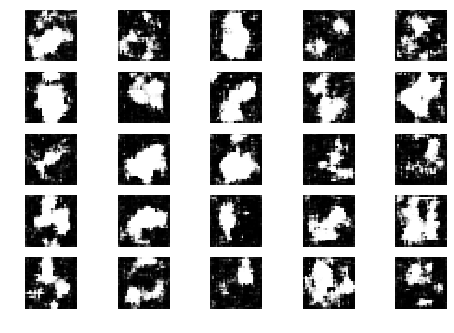

Epoch 0 Batch 151/187 [D loss: 0.208177, acc.: 93.75%] [G loss: 0.009750]
Epoch 0 Batch 152/187 [D loss: 0.326805, acc.: 81.25%] [G loss: 0.000431]
Epoch 0 Batch 153/187 [D loss: 0.129577, acc.: 93.75%] [G loss: 0.001280]
Epoch 0 Batch 154/187 [D loss: 0.194455, acc.: 93.75%] [G loss: 0.030681]
Epoch 0 Batch 155/187 [D loss: 0.417418, acc.: 75.00%] [G loss: 0.038268]
Epoch 0 Batch 156/187 [D loss: 0.059795, acc.: 100.00%] [G loss: 0.005039]
Epoch 0 Batch 157/187 [D loss: 0.021981, acc.: 100.00%] [G loss: 0.011517]
Epoch 0 Batch 158/187 [D loss: 0.061957, acc.: 96.88%] [G loss: 0.010465]
Epoch 0 Batch 159/187 [D loss: 0.193599, acc.: 87.50%] [G loss: 0.000300]
Epoch 0 Batch 160/187 [D loss: 0.258311, acc.: 84.38%] [G loss: 0.002849]
Epoch 0 Batch 161/187 [D loss: 0.046288, acc.: 100.00%] [G loss: 0.026910]
Epoch 0 Batch 162/187 [D loss: 0.368535, acc.: 93.75%] [G loss: 0.036903]
Epoch 0 Batch 163/187 [D loss: 0.070188, acc.: 96.88%] [G loss: 0.004278]
Epoch 0 Batch 164/187 [D loss: 0.19

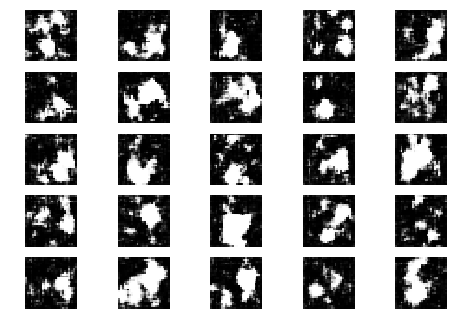

Epoch 1 Batch 1/187 [D loss: 0.106928, acc.: 96.88%] [G loss: 0.005896]
Epoch 1 Batch 2/187 [D loss: 0.140566, acc.: 93.75%] [G loss: 0.015997]
Epoch 1 Batch 3/187 [D loss: 0.119687, acc.: 93.75%] [G loss: 0.004099]
Epoch 1 Batch 4/187 [D loss: 0.076354, acc.: 96.88%] [G loss: 0.000745]
Epoch 1 Batch 5/187 [D loss: 0.275158, acc.: 93.75%] [G loss: 0.001113]
Epoch 1 Batch 6/187 [D loss: 0.030771, acc.: 100.00%] [G loss: 0.014952]
Epoch 1 Batch 7/187 [D loss: 0.321588, acc.: 84.38%] [G loss: 0.000116]
Epoch 1 Batch 8/187 [D loss: 0.102067, acc.: 93.75%] [G loss: 0.000476]
Epoch 1 Batch 9/187 [D loss: 0.082680, acc.: 100.00%] [G loss: 0.013480]
Epoch 1 Batch 10/187 [D loss: 0.214124, acc.: 90.62%] [G loss: 0.063745]
Epoch 1 Batch 11/187 [D loss: 0.250122, acc.: 87.50%] [G loss: 0.001537]
Epoch 1 Batch 12/187 [D loss: 0.057939, acc.: 96.88%] [G loss: 0.000634]
Epoch 1 Batch 13/187 [D loss: 0.031604, acc.: 100.00%] [G loss: 0.000252]
Epoch 1 Batch 14/187 [D loss: 0.056720, acc.: 100.00%] [G

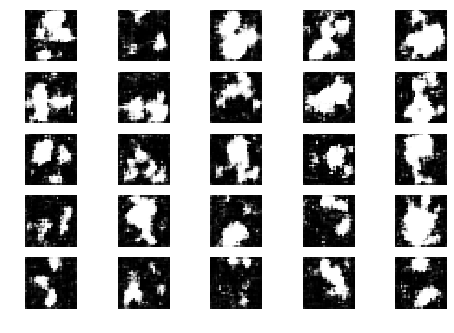

Epoch 1 Batch 51/187 [D loss: 0.044419, acc.: 96.88%] [G loss: 0.000621]
Epoch 1 Batch 52/187 [D loss: 0.034918, acc.: 100.00%] [G loss: 0.000095]
Epoch 1 Batch 53/187 [D loss: 0.016160, acc.: 100.00%] [G loss: 0.000757]
Epoch 1 Batch 54/187 [D loss: 0.116501, acc.: 93.75%] [G loss: 0.000431]
Epoch 1 Batch 55/187 [D loss: 0.012693, acc.: 100.00%] [G loss: 0.000174]
Epoch 1 Batch 56/187 [D loss: 0.034858, acc.: 96.88%] [G loss: 0.000314]
Epoch 1 Batch 57/187 [D loss: 0.066689, acc.: 96.88%] [G loss: 0.006897]
Epoch 1 Batch 58/187 [D loss: 0.012508, acc.: 100.00%] [G loss: 0.006275]
Epoch 1 Batch 59/187 [D loss: 0.017334, acc.: 100.00%] [G loss: 0.000310]
Epoch 1 Batch 60/187 [D loss: 0.181642, acc.: 93.75%] [G loss: 0.000265]
Epoch 1 Batch 61/187 [D loss: 0.028184, acc.: 100.00%] [G loss: 0.000234]
Epoch 1 Batch 62/187 [D loss: 0.027404, acc.: 100.00%] [G loss: 0.000146]
Epoch 1 Batch 63/187 [D loss: 0.061743, acc.: 96.88%] [G loss: 0.000028]
Epoch 1 Batch 64/187 [D loss: 0.025927, acc.

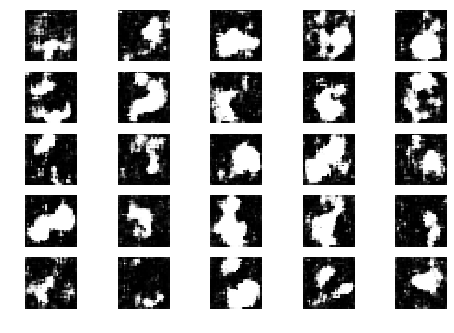

Epoch 1 Batch 101/187 [D loss: 0.054354, acc.: 100.00%] [G loss: 0.002142]
Epoch 1 Batch 102/187 [D loss: 0.053954, acc.: 96.88%] [G loss: 0.001696]
Epoch 1 Batch 103/187 [D loss: 0.008331, acc.: 100.00%] [G loss: 0.001100]
Epoch 1 Batch 104/187 [D loss: 0.039839, acc.: 100.00%] [G loss: 0.000046]
Epoch 1 Batch 105/187 [D loss: 0.014346, acc.: 100.00%] [G loss: 0.000537]
Epoch 1 Batch 106/187 [D loss: 0.025239, acc.: 100.00%] [G loss: 0.000445]
Epoch 1 Batch 107/187 [D loss: 0.024553, acc.: 100.00%] [G loss: 0.000151]
Epoch 1 Batch 108/187 [D loss: 0.057676, acc.: 100.00%] [G loss: 0.000250]
Epoch 1 Batch 109/187 [D loss: 0.006005, acc.: 100.00%] [G loss: 0.000146]
Epoch 1 Batch 110/187 [D loss: 0.043738, acc.: 96.88%] [G loss: 0.000779]
Epoch 1 Batch 111/187 [D loss: 0.081765, acc.: 93.75%] [G loss: 0.001114]
Epoch 1 Batch 112/187 [D loss: 0.053925, acc.: 100.00%] [G loss: 0.000053]
Epoch 1 Batch 113/187 [D loss: 0.079375, acc.: 93.75%] [G loss: 0.000229]
Epoch 1 Batch 114/187 [D loss

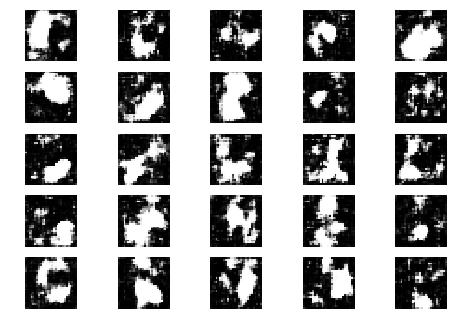

Epoch 1 Batch 151/187 [D loss: 0.004488, acc.: 100.00%] [G loss: 0.008095]
Epoch 1 Batch 152/187 [D loss: 0.001462, acc.: 100.00%] [G loss: 0.000296]
Epoch 1 Batch 153/187 [D loss: 0.007226, acc.: 100.00%] [G loss: 0.004543]
Epoch 1 Batch 154/187 [D loss: 0.027444, acc.: 100.00%] [G loss: 0.000034]
Epoch 1 Batch 155/187 [D loss: 0.003316, acc.: 100.00%] [G loss: 0.000076]
Epoch 1 Batch 156/187 [D loss: 0.011512, acc.: 100.00%] [G loss: 0.000062]
Epoch 1 Batch 157/187 [D loss: 0.003925, acc.: 100.00%] [G loss: 0.000241]
Epoch 1 Batch 158/187 [D loss: 0.050059, acc.: 100.00%] [G loss: 0.000016]
Epoch 1 Batch 159/187 [D loss: 0.055766, acc.: 96.88%] [G loss: 0.000039]
Epoch 1 Batch 160/187 [D loss: 0.004955, acc.: 100.00%] [G loss: 0.000392]
Epoch 1 Batch 161/187 [D loss: 0.017998, acc.: 100.00%] [G loss: 0.000261]
Epoch 1 Batch 162/187 [D loss: 0.004243, acc.: 100.00%] [G loss: 0.000131]
Epoch 1 Batch 163/187 [D loss: 0.017984, acc.: 100.00%] [G loss: 0.000040]
Epoch 1 Batch 164/187 [D l

In [171]:
main()

In [0]:
files.download('generator1.h5')

In [0]:
files.download('discriminator1.h5')

In [0]:
files.download('combined1.h5')

In [0]:
generator1 = load_model('generator1.h5')
discriminator1 = load_model('discriminator1.h5')
combined1 = load_model('combined1.h5')



In [0]:
train(generator1, discriminator1, combined1,
          epochs=1, batch_size=32, save_interval=1)

In [0]:

##encodermodel = build_generator()
##encodermodel.summary()

##noise = np.random.normal(0, 1, (50, 100))
##fake_images = encodermodel.predict(noise)


In [0]:
##encodermodel.predict(inputnoise)